# All necessary inputs. Identical across all the different models.

In [ ]:
# All torch imports needed
import torch.nn as nn
from torchvision.models import resnet50
from torchsummary import summary
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import time
from threading import current_thread
import torch.nn.functional as F
from torchvision import transforms


# Fetching NPZ file after being created by the 7 Layer CNN


In [ ]:
# fetch plantvillage data from npz file
data = np.load('/content/drive/MyDrive/Dissertation Dataset/plant_disease_data.npz')
X = data['images']
y = data['labels']

# print out the different y values
print(np.unique(y))

print("Images Shape = ", X.shape)
print("Labels Shape = ", y.shape)


[0 1 2 3 4]
Images Shape =  (20638, 256, 256, 3)
Labels Shape =  (20638,)


# Enabling GPU Acceleration

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Get the training and testing images ready:
# Define split ratios
train_ratio = 0.7  # 70% for training
val_ratio = 0.15  # 15% for validation
test_ratio = 0.15  # 15% for testing

# Step 1: Split into training and remaining data
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=(1 - train_ratio), random_state=42, stratify=y)

# Step 2: Split remaining data into validation and testing
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42, stratify=y_rem)

# Confirm split sizes
print("Training Set: ", X_train.shape, y_train.shape)
print("Validation Set: ", X_val.shape, y_val.shape)
print("Testing Set: ", X_test.shape, y_test.shape)

Training Set:  (14446, 256, 256, 3) (14446,)
Validation Set:  (3096, 256, 256, 3) (3096,)
Testing Set:  (3096, 256, 256, 3) (3096,)


In [ ]:
# type of the images
print("Type of X_train: ", type(X_train))
print("Type of X_val: ", type(X_val))
print("Type of X_test: ", type(X_test))

Type of X_train:  <class 'numpy.ndarray'>
Type of X_val:  <class 'numpy.ndarray'>
Type of X_test:  <class 'numpy.ndarray'>


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Convert them into tensors
X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test = torch.tensor(y_test, dtype=torch.long)

# print the types
print("Type of X_train: ", type(X_train))
print("Type of X_val: ", type(X_val))
print("Type of X_test: ", type(X_test))


Type of X_train:  <class 'torch.Tensor'>
Type of X_val:  <class 'torch.Tensor'>
Type of X_test:  <class 'torch.Tensor'>


In [ ]:
# Set up a Resnet50 model from torchvision
res_model = resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s]


In [ ]:
# put model on gpu
res_model = res_model.to(device)

In [ ]:
# Data loader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# modify the fully connected layer to have 5 classes
# Healthy, Fungal   , Viral    , Bacterial and Mites
# 0      , 1        , 2         , 3            ,4
# Set up a Resnet50 model from torchvision
res_model = resnet50(pretrained=True)
num_classes = 5
res_model.fc = nn.Linear(res_model.fc.in_features, num_classes)
res_model = res_model.to(device)
summary(res_model, (3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(res_model.parameters(), lr=0.001)

In [ ]:
# Training
start_time = time.time()
res_model = res_model.to(device)
num_epochs = 20
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(num_epochs):
  trn_corr = 0
  tst_corr = 0

  # Training section
  res_model.train()
  for batch, (X_train, y_train) in enumerate(train_loader):
    batch += 1

    X_train, y_train = X_train.to(device), y_train.to(device)

    y_pred = res_model(X_train)
    loss = criterion(y_pred, y_train)
    predicted = torch.max(y_pred.data, 1)[1] # Get the predicted class

    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch%200 == 0:
      print(f' Epoch {i} - Batch {batch} - Loss {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)
  # Testing
  res_model.eval()
  with torch.no_grad(): # We want no gradient so we don't update our weights and biases with test data
    for batch, (X_test, y_test) in enumerate(test_loader):
      X_test, y_test = X_test.to(device), y_test.to(device)
      y_val = res_model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)


current_time = time.time()
elapsed_time = current_time - start_time
print(f"Elapsed time: {elapsed_time/60:.2f} minutes")




 Epoch 0 - Batch 200 - Loss 0.0534154511988163
 Epoch 1 - Batch 200 - Loss 0.08128979057073593
 Epoch 2 - Batch 200 - Loss 0.02975890412926674
 Epoch 3 - Batch 200 - Loss 0.1852216124534607
 Epoch 4 - Batch 200 - Loss 0.048775672912597656
 Epoch 5 - Batch 200 - Loss 0.024125030264258385
 Epoch 6 - Batch 200 - Loss 0.04012902081012726
 Epoch 7 - Batch 200 - Loss 0.029656188562512398
 Epoch 8 - Batch 200 - Loss 0.14282414317131042
 Epoch 9 - Batch 200 - Loss 0.009178593754768372
 Epoch 10 - Batch 200 - Loss 0.0006915368721820414
 Epoch 11 - Batch 200 - Loss 0.0038810288533568382
 Epoch 12 - Batch 200 - Loss 0.031910352408885956
 Epoch 13 - Batch 200 - Loss 0.003613443113863468
 Epoch 14 - Batch 200 - Loss 0.01278126984834671
 Epoch 15 - Batch 200 - Loss 0.004170444328337908
 Epoch 16 - Batch 200 - Loss 0.0848136618733406
 Epoch 17 - Batch 200 - Loss 0.01034722663462162
 Epoch 18 - Batch 200 - Loss 0.05819237232208252
 Epoch 19 - Batch 200 - Loss 0.0039856829680502415
Elapsed time: 58.38 

In [ ]:
# Convert tensor to number if necessary, depending on PyTorch version
train_accuracy = [100.0 * correct.item() / len(train_dataset) for correct in train_correct]
test_accuracy = [100.0 * correct.item() / len(test_dataset) for correct in test_correct]

# Display accuracies for each epoch
for epoch, (train_acc, test_acc) in enumerate(zip(train_accuracy, test_accuracy)):
    print(f'Epoch {epoch}: Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

Epoch 0: Train Accuracy: 90.60%, Test Accuracy: 88.50%
Epoch 1: Train Accuracy: 95.15%, Test Accuracy: 92.54%
Epoch 2: Train Accuracy: 97.01%, Test Accuracy: 94.06%
Epoch 3: Train Accuracy: 97.52%, Test Accuracy: 85.63%
Epoch 4: Train Accuracy: 98.51%, Test Accuracy: 95.22%
Epoch 5: Train Accuracy: 98.15%, Test Accuracy: 90.50%
Epoch 6: Train Accuracy: 97.93%, Test Accuracy: 96.77%
Epoch 7: Train Accuracy: 98.37%, Test Accuracy: 98.00%
Epoch 8: Train Accuracy: 99.08%, Test Accuracy: 98.55%
Epoch 9: Train Accuracy: 99.32%, Test Accuracy: 98.32%
Epoch 10: Train Accuracy: 98.81%, Test Accuracy: 90.96%
Epoch 11: Train Accuracy: 98.93%, Test Accuracy: 99.06%
Epoch 12: Train Accuracy: 99.02%, Test Accuracy: 93.25%
Epoch 13: Train Accuracy: 99.12%, Test Accuracy: 93.77%
Epoch 14: Train Accuracy: 98.84%, Test Accuracy: 98.35%
Epoch 15: Train Accuracy: 99.10%, Test Accuracy: 97.09%
Epoch 16: Train Accuracy: 99.59%, Test Accuracy: 96.74%
Epoch 17: Train Accuracy: 99.08%, Test Accuracy: 98.16%
Ep

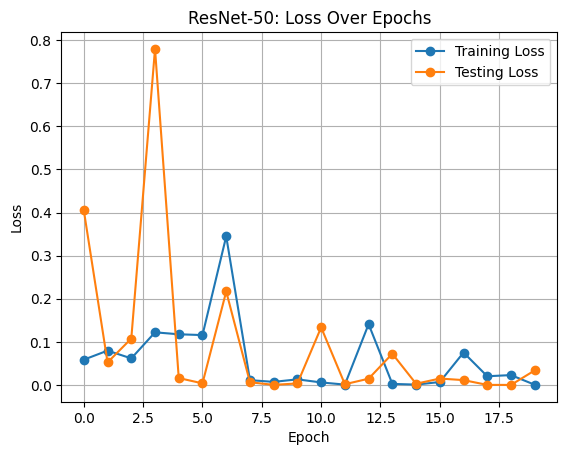

In [ ]:
import matplotlib.pyplot as plt
# Move tensors to CPU and convert to NumPy
train_losses_cpu = [loss.cpu().detach().numpy() for loss in train_losses]
test_losses_cpu = [loss.cpu().detach().numpy() for loss in test_losses]

# Plot the loss
plt.plot(train_losses_cpu, marker='o', linestyle='-', label='Training Loss')
plt.plot(test_losses_cpu, marker='o', linestyle='-', label='Testing Loss')
plt.title('ResNet-50: Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 0: Train Accuracy: 90.60%, Test Accuracy: 88.50%
Epoch 1: Train Accuracy: 95.15%, Test Accuracy: 92.54%
Epoch 2: Train Accuracy: 97.01%, Test Accuracy: 94.06%
Epoch 3: Train Accuracy: 97.52%, Test Accuracy: 85.63%
Epoch 4: Train Accuracy: 98.51%, Test Accuracy: 95.22%
Epoch 5: Train Accuracy: 98.15%, Test Accuracy: 90.50%
Epoch 6: Train Accuracy: 97.93%, Test Accuracy: 96.77%
Epoch 7: Train Accuracy: 98.37%, Test Accuracy: 98.00%
Epoch 8: Train Accuracy: 99.08%, Test Accuracy: 98.55%
Epoch 9: Train Accuracy: 99.32%, Test Accuracy: 98.32%
Epoch 10: Train Accuracy: 98.81%, Test Accuracy: 90.96%
Epoch 11: Train Accuracy: 98.93%, Test Accuracy: 99.06%
Epoch 12: Train Accuracy: 99.02%, Test Accuracy: 93.25%
Epoch 13: Train Accuracy: 99.12%, Test Accuracy: 93.77%
Epoch 14: Train Accuracy: 98.84%, Test Accuracy: 98.35%
Epoch 15: Train Accuracy: 99.10%, Test Accuracy: 97.09%
Epoch 16: Train Accuracy: 99.59%, Test Accuracy: 96.74%
Epoch 17: Train Accuracy: 99.08%, Test Accuracy: 98.16%
Ep

Text(0.5, 1.0, 'ResNet-50: Training and Testing Accuracy Over 20 Epochs')

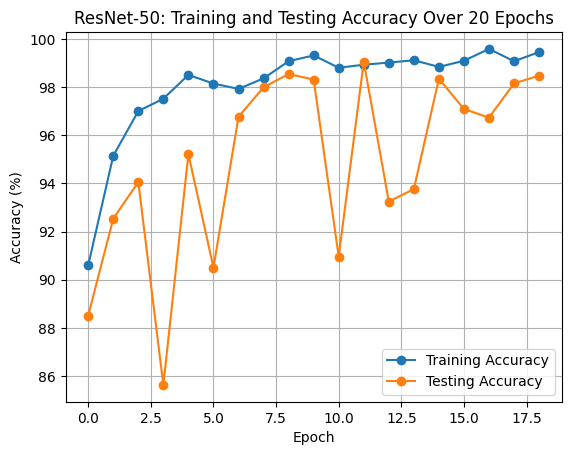

In [ ]:
# Convert tensor to number if necessary, depending on PyTorch version
train_accuracy = [100.0 * correct.item() / len(train_dataset) for correct in train_correct]
test_accuracy = [100.0 * correct.item() / len(test_dataset) for correct in test_correct]

# Display accuracies for each epoch, ignore last one
train_accuracy = train_accuracy[:-1]
test_accuracy = test_accuracy[:-1]

# Display accuracies for each epoch
for epoch, (train_acc, test_acc) in enumerate(zip(train_accuracy, test_accuracy)):
    print(f'Epoch {epoch}: Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')
# plot the percentages
import matplotlib.pyplot as plt
plt.plot(train_accuracy, marker='o', linestyle='-', label='Training Accuracy')
plt.plot(test_accuracy, marker='o', linestyle='-', label='Testing Accuracy')
# grid
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('ResNet-50: Training and Testing Accuracy Over 20 Epochs')

In [ ]:
# Pass all the images in the val_dataset and print them out with actual label and predicted label
res_model.eval()  # Set model to evaluation mode

all_preds = []  # Store predicted labels
all_actuals = []  # Store actual labels

res_model.to(device)
# Loop through the validation dataset
with torch.no_grad():  # Disable gradient computation

    for data, labels in val_loader:
        # Pass the images through the model
        data, labels = data.to(device), labels.to(device)
        predictions = res_model(data)

        # Apply softmax and get the predicted class
        probs = F.softmax(predictions, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)

        # Store predictions and actual labels
        all_preds.extend(predicted_labels.cpu().numpy())
        all_actuals.extend(labels.cpu().numpy())

# Print comparison
for i in range(len(all_preds)):
    print(f"Image {i}: Actual Label = {all_actuals[i]}, Predicted Label = {all_preds[i]}")

Image 0: Actual Label = 1, Predicted Label = 1
Image 1: Actual Label = 1, Predicted Label = 1
Image 2: Actual Label = 2, Predicted Label = 2
Image 3: Actual Label = 3, Predicted Label = 3
Image 4: Actual Label = 1, Predicted Label = 1
Image 5: Actual Label = 3, Predicted Label = 3
Image 6: Actual Label = 1, Predicted Label = 3
Image 7: Actual Label = 0, Predicted Label = 0
Image 8: Actual Label = 4, Predicted Label = 4
Image 9: Actual Label = 0, Predicted Label = 0
Image 10: Actual Label = 2, Predicted Label = 2
Image 11: Actual Label = 3, Predicted Label = 3
Image 12: Actual Label = 1, Predicted Label = 1
Image 13: Actual Label = 1, Predicted Label = 1
Image 14: Actual Label = 1, Predicted Label = 1
Image 15: Actual Label = 0, Predicted Label = 0
Image 16: Actual Label = 1, Predicted Label = 1
Image 17: Actual Label = 2, Predicted Label = 2
Image 18: Actual Label = 1, Predicted Label = 1
Image 19: Actual Label = 1, Predicted Label = 1
Image 20: Actual Label = 1, Predicted Label = 1
Im

In [ ]:
# get the accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_actuals, all_preds)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 98.03%


In [ ]:
# save torch model
torch.save(res_model.state_dict(), '/content/drive/MyDrive/Dissertation Dataset/resnet50_20epoch.pth')